In [266]:
import numpy as np
from scipy.stats import sem
from os.path import expanduser
import scipy.io
import os.path
from pyret.filtertools import getsta
from sklearn.decomposition import PCA

# import my functions
#import info_theory_functions as info
#from lnl_model_functions import *
#from atick_redlich_functions import *
#from get_davids_data import *
#from image_processing_functions import *


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

import mpld3

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load stim and spikes

In [334]:
stim_dir = expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/high contrast - low contrast/2009_0818/stimulus')
spikes_dir = expanduser('~/Documents/Stanford/00 Baccus Lab/Surround size project/high contrast - low contrast/2009_0818/spikes')

frame_rate = 0.0333462
frames = 450
offset = 16.6646995544434 # includes frame_rate*frames for the first high contrast probe
fudge  = .15

stim = scipy.io.loadmat(stim_dir + '/stim.mat', squeeze_me=True)
spikes = []
for i in xrange(25):
    filename = 'c%s_0.txt' %(str(i))
    full_path = spikes_dir + '/' + filename
    if os.path.isfile(full_path):
        this_cell = np.loadtxt(full_path, skiprows=1)
        # remove the first adapt sequence from consideration
        tmp = this_cell - offset + fudge
        spikes.append(tmp[tmp>=0])

# Create time vector for stimulus

In [335]:
stim['adapt'].shape

(96, 450, 53)

In [336]:
stim['probe'].shape

(96, 450, 53)

In [337]:
stim_time = np.linspace(0, 
                     frame_rate*np.prod(stim['adapt'].shape[1:]) + frame_rate*np.prod(stim['probe'].shape[1:]), 
                     np.prod(stim['probe'].shape[1:]) + np.prod(stim['adapt'].shape[1:]))

In [338]:
print len(stim_time), np.max(stim_time)

47700 1590.61374


In [339]:
num_trials = stim['adapt'].shape[2]
duration_per_trial = stim['adapt'].shape[1] * frame_rate

In [340]:
duration_per_trial

15.00579

In [341]:
spikes[0][0]

14.229700445556601

# Create stimulus

Sequence is High-Low-High-Low-..., but with the first High contrast sequence removed. Low is "adapt", high is "probe". So after subtracting first ~15 seconds, sequence should be adapt-probe-adapt-probe-...

In [342]:
stimulus = np.zeros((stim['adapt'].shape[0], stim['adapt'].shape[1], stim['adapt'].shape[2]+stim['probe'].shape[2]))

In [343]:
for block in xrange(stimulus.shape[2]):
    if block % 2 == 0:
        stimulus[:,:,block] = stim['adapt'][:,:,block/2]
    else:
        stimulus[:,:,block] = stim['probe'][:,:,(block-1)/2]

In [344]:
stimulus = stimulus.reshape((stimulus.shape[0], np.prod(stimulus.shape[1:3])), order='F')

In [345]:
stimulus.shape

(96, 47700)

# Look at full sta, ignoring high/low contrast

In [346]:
full_sta, time_axis = getsta(stim_time, stimulus, spikes[0], 40)

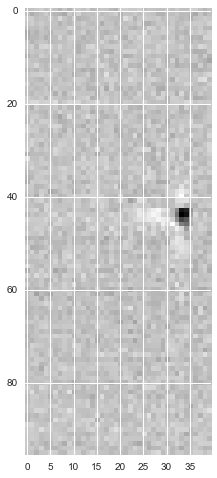

In [347]:
imshow(full_sta)

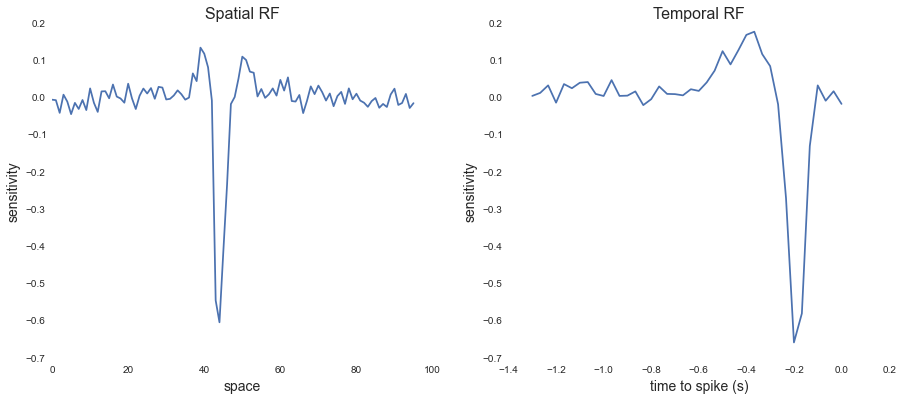

In [348]:
temporal_pca = PCA(n_components=1)
spatial_pca  = PCA(n_components=1)
temporal_pca.fit(full_sta)
spatial_pca.fit(full_sta.T)
temporal_rf = temporal_pca.components_[0]
spatial_rf  = spatial_pca.components_[0]

fig = gcf()
fig.set_size_inches((15,6))
subplot(1,2,1)
plot(spatial_rf)
xlabel('space', fontsize=14)
ylabel('sensitivity', fontsize=14)
title('Spatial RF', fontsize=16)
subplot(1,2,2)
plot(time_axis, temporal_rf)
xlabel('time to spike (s)', fontsize=14)
ylabel('sensitivity', fontsize=14)
title('Temporal RF', fontsize=16)

# Separate high and low contrast spikes

In [355]:
cell = 10
low_contrast  = []
high_contrast = []
wait_time = 5 # wait 5 seconds to adapt before using the spikes to compute high or low
for trial in xrange(2*num_trials):
    time_interval = [trial*duration_per_trial, (trial+1)*duration_per_trial]
    # sequence is low (adapt), high (probe), low, high, ...
    if trial % 2 == 1:
        high_contrast.append(spikes[cell][(spikes[cell] > time_interval[0] + wait_time) & (spikes[cell] <= time_interval[1])])
    else:
        low_contrast.append(spikes[cell][(spikes[cell] > time_interval[0] + wait_time) & (spikes[cell] <= time_interval[1])])

In [356]:
sta_low, time_axis_low   = getsta(stim_time, stimulus, [item for sublist in low_contrast for item in sublist], 20)
sta_high, time_axis_high = getsta(stim_time, stimulus, [item for sublist in high_contrast for item in sublist], 20)

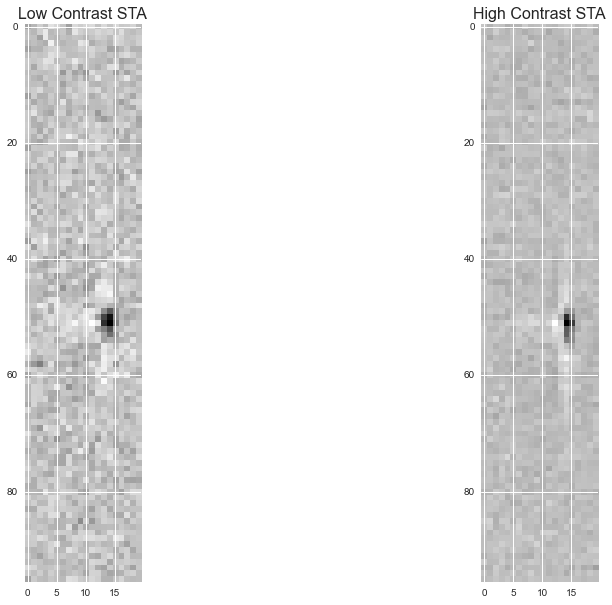

In [357]:
fig = gcf()
fig.set_size_inches((15,10))
subplot(1,2,1)
imshow(sta_low)
title('Low Contrast STA', fontsize=16)
subplot(1,2,2)
imshow(sta_high)
title('High Contrast STA', fontsize=16)

#### High Contrast

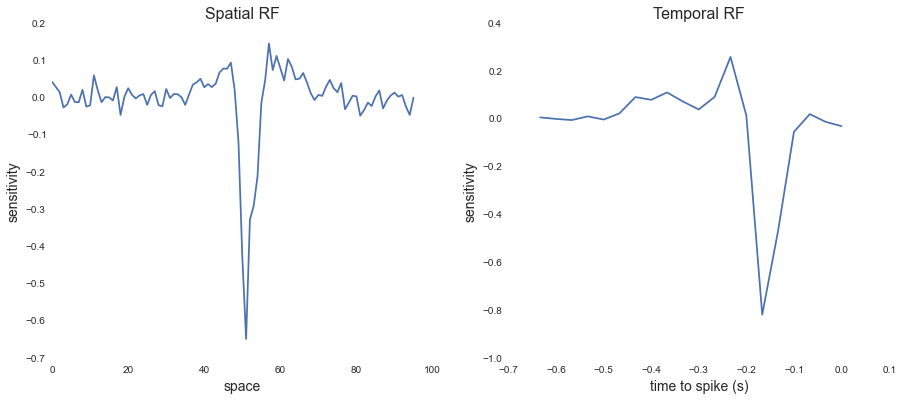

In [366]:
temporal_pca_high = PCA(n_components=1)
spatial_pca_high  = PCA(n_components=1)
temporal_pca_high.fit(sta_high)
spatial_pca_high.fit(sta_high.T)
temporal_rf_high = temporal_pca_high.components_[0]
spatial_rf_high  = spatial_pca_high.components_[0]

fig = gcf()
fig.set_size_inches((15,6))
subplot(1,2,1)
plot(spatial_rf_high)
xlabel('space', fontsize=14)
ylabel('sensitivity', fontsize=14)
title('Spatial RF', fontsize=16)
subplot(1,2,2)
plot(time_axis_high, -temporal_rf_high)
xlabel('time to spike (s)', fontsize=14)
ylabel('sensitivity', fontsize=14)
title('Temporal RF', fontsize=16)

#### Low Contrast

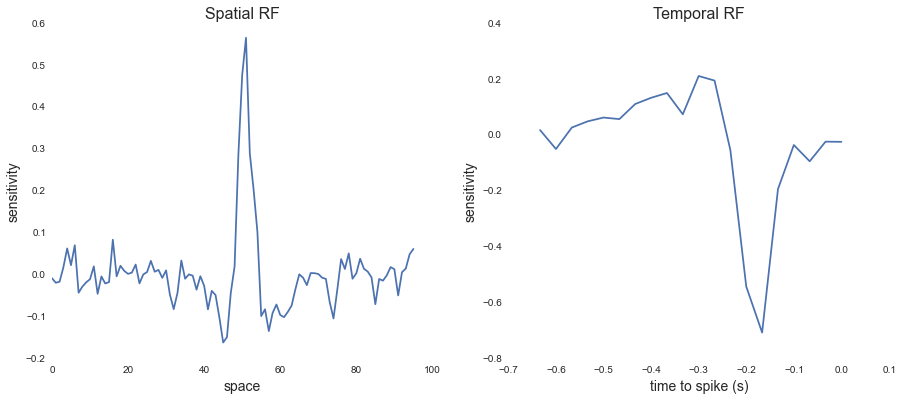

In [361]:
temporal_pca_low = PCA(n_components=1)
spatial_pca_low  = PCA(n_components=1)
temporal_pca_low.fit(sta_low)
spatial_pca_low.fit(sta_low.T)
temporal_rf_low = temporal_pca_low.components_[0]
spatial_rf_low  = spatial_pca_low.components_[0]

fig = gcf()
fig.set_size_inches((15,6))
subplot(1,2,1)
plot(spatial_rf_low)
xlabel('space', fontsize=14)
ylabel('sensitivity', fontsize=14)
title('Spatial RF', fontsize=16)
subplot(1,2,2)
plot(time_axis_low, temporal_rf_low)
xlabel('time to spike (s)', fontsize=14)
ylabel('sensitivity', fontsize=14)
title('Temporal RF', fontsize=16)

## Now plot the low and high contrast spatial RFs on top of each other

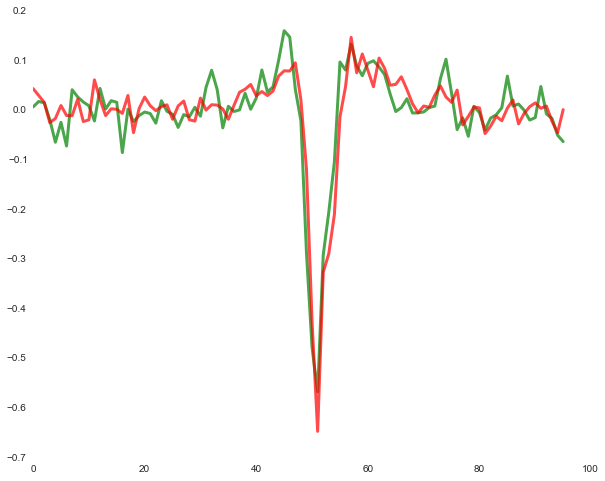

In [364]:
plot(-spatial_rf_low, 'g', alpha=0.7, linewidth=3)
plot(spatial_rf_high, 'r', alpha=0.7, linewidth=3)

## Visualize all overlays for the cells recorded

In [368]:
len(spikes)

14

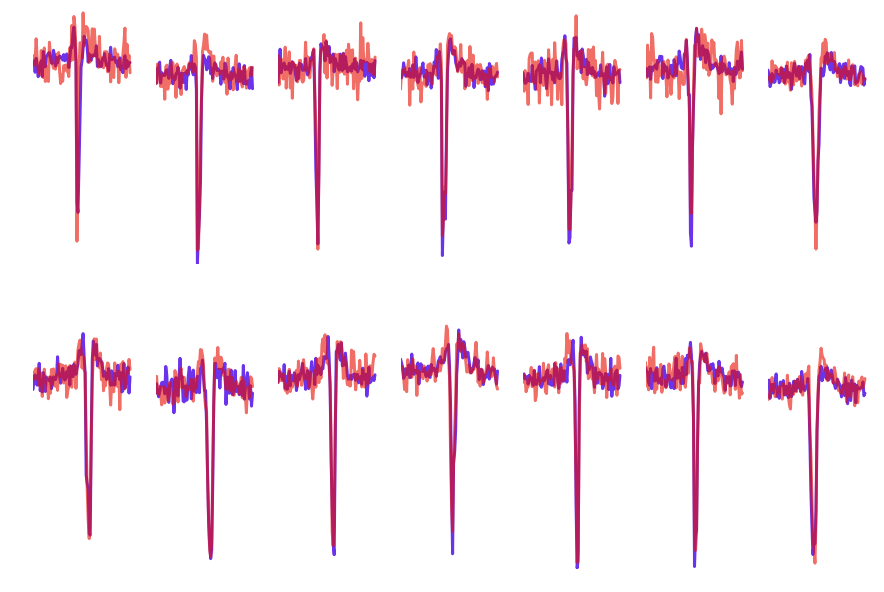

In [396]:
wait_time = 5 # wait 5 seconds to adapt before using the spikes to compute high or low

fig = gcf()
fig.set_size_inches((15,10))
num_cols = 7
num_rows = 2
idxs = range(num_cols)
for y in range(num_cols):
    for i in range(num_rows):
        plt_index = i * num_cols + y + 1
        cell = plt_index -1 
        low_contrast  = []
        high_contrast = []
        for trial in xrange(2*num_trials):
            time_interval = [trial*duration_per_trial, (trial+1)*duration_per_trial]
            # sequence is low (adapt), high (probe), low, high, ...
            if trial % 2 == 1:
                high_contrast.append(spikes[cell][(spikes[cell] > time_interval[0] + wait_time) & (spikes[cell] <= time_interval[1])])
            else:
                low_contrast.append(spikes[cell][(spikes[cell] > time_interval[0] + wait_time) & (spikes[cell] <= time_interval[1])])
        sta_low, time_axis_low   = getsta(stim_time, stimulus, [item for sublist in low_contrast for item in sublist], 20)
        sta_high, time_axis_high = getsta(stim_time, stimulus, [item for sublist in high_contrast for item in sublist], 20)
        spatial_pca_high  = PCA(n_components=1)
        spatial_pca_high.fit(sta_high.T)
        spatial_rf_high   = spatial_pca_high.components_[0]
        spatial_pca_low   = PCA(n_components=1)
        spatial_pca_low.fit(sta_low.T)
        spatial_rf_low    = spatial_pca_low.components_[0]
        sign_high         = -1*np.sign(spatial_rf_high[np.argmax(abs(spatial_rf_high))])
        sign_low          = -1*np.sign(spatial_rf_low[np.argmax(abs(spatial_rf_low))])
        
        # plot the spatial receptive fields
        subplot(num_rows, num_cols, plt_index)
        plot(sign_high * spatial_rf_high, color='#4700E6', alpha=0.8, linewidth=3)
        plot(sign_low * spatial_rf_low, color='#E60E00', alpha=0.6, linewidth=3)
        axis('off')
#mpld3.display()